# **Titanic, disaster prediction**

### **POWERED BY 42RandomState**

In this notebook, we use the Titanic dataset to build various machine learning models to predict the survival probability of the passengers. We will follow these steps:
- Data preprocessing.
- Machine learning model creation and evaluation.
- Hyperparameter optimization using RandomizedSearchCV.
- Building an ensemble model (election classifier) ​​to get a final prediction.

## **1) Data analysis**

First let's take a look at the data, create new features and plot everything on graphs

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

train_set = pd.read_csv('/kaggle/input/titanic/train.csv')
test_set = pd.read_csv('/kaggle/input/titanic/test.csv')

2025-04-25 08:52:03.892030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745571124.109696      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745571124.170567      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#CREATE NEW FEATURES IN THE TRAIN SET
train_set['Title'] = train_set['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Jonkheer', 'Sir', 'Lady', 'Don', 'Dona', 'Countess', 'Capt']
train_set['Title'] = train_set['Title'].replace(rare_titles, 'Rare')
train_set['CabinLetter'] = train_set['Cabin'].astype(str).str[0]
train_set['TicketPrefix'] = train_set['Ticket'].apply(lambda x: x.split()[0] if not x.isdigit() else 'None')
train_set['FamilySize'] = train_set['SibSp'] + train_set['Parch'] + 1
train_set['IsAlone'] = (train_set['FamilySize'] == 1).astype(int)
train_set['Age*Class'] = train_set['Age'] * train_set['Pclass']
train_set['HadCabin'] = (train_set['Cabin'] != '') * 1
train_set['FarePerPerson'] = train_set['Fare'] / train_set['FamilySize']

In [3]:
#CREATE NEW FEATURES IN THE TEST SET
test_set['Title'] = test_set['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_set['Title'] = test_set['Title'].replace(rare_titles, 'Rare')
test_set['CabinLetter'] = test_set['Cabin'].astype(str).str[0]
test_set['TicketPrefix'] = test_set['Ticket'].apply(lambda x: x.split()[0] if not x.isdigit() else 'None')
test_set['FamilySize'] = test_set['SibSp'] + test_set['Parch'] + 1
test_set['IsAlone'] = (test_set['FamilySize'] == 1).astype(int)
test_set['Age*Class'] = test_set['Age'] * test_set['Pclass']
test_set['HadCabin'] = (test_set['Cabin'] != '') * 1
test_set['FarePerPerson'] = test_set['Fare'] / test_set['FamilySize']

In [4]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinLetter,TicketPrefix,FamilySize,IsAlone,Age*Class,HadCabin,FarePerPerson
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,n,A/5,2,0,66.0,1,3.62500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,PC,2,0,38.0,1,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,n,STON/O2.,1,1,78.0,1,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,None,2,0,35.0,1,26.55000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,n,None,1,1,105.0,1,8.05000


In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            714 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       889 non-null    object 
 12  Title          891 non-null    object 
 13  CabinLetter    891 non-null    object 
 14  TicketPrefix   891 non-null    object 
 15  FamilySize     891 non-null    int64  
 16  IsAlone        891 non-null    int64  
 17  Age*Class      714 non-null    float64
 18  HadCabin  

In [6]:
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Age*Class,HadCabin,FarePerPerson
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,714.000000,891.0,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.904602,0.602694,61.938151,1.0,19.916375
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,1.613459,0.489615,34.379609,0.0,35.841257
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000,0.920000,1.0,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.000000,0.000000,38.000000,1.0,7.250000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,1.000000,58.000000,1.0,8.300000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,2.000000,1.000000,81.000000,1.0,23.666667
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000,222.000000,1.0,512.329200


In [7]:
#Check if there are heavy-tailed data
from scipy.stats import skew

numeric_cols = train_set.select_dtypes(include=np.number).columns
skewed_feats = train_set[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

print("Skew of numerical features:")
print(skewed_feats)

skewed_features = skewed_feats[skewed_feats > 0.8].index.tolist()
print("High skew features:", skewed_features)

skewed_features = [col for col in skewed_features if col in train_set.columns]

Skew of numerical features:
FarePerPerson    7.752515
Fare             4.779253
SibSp            3.689128
Parch            2.744487
FamilySize       2.722848
Age*Class        0.839033
Survived         0.477717
Age              0.388290
PassengerId      0.000000
IsAlone         -0.419723
Pclass          -0.629486
HadCabin              NaN
dtype: float64
High skew features: ['FarePerPerson', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'Age*Class']


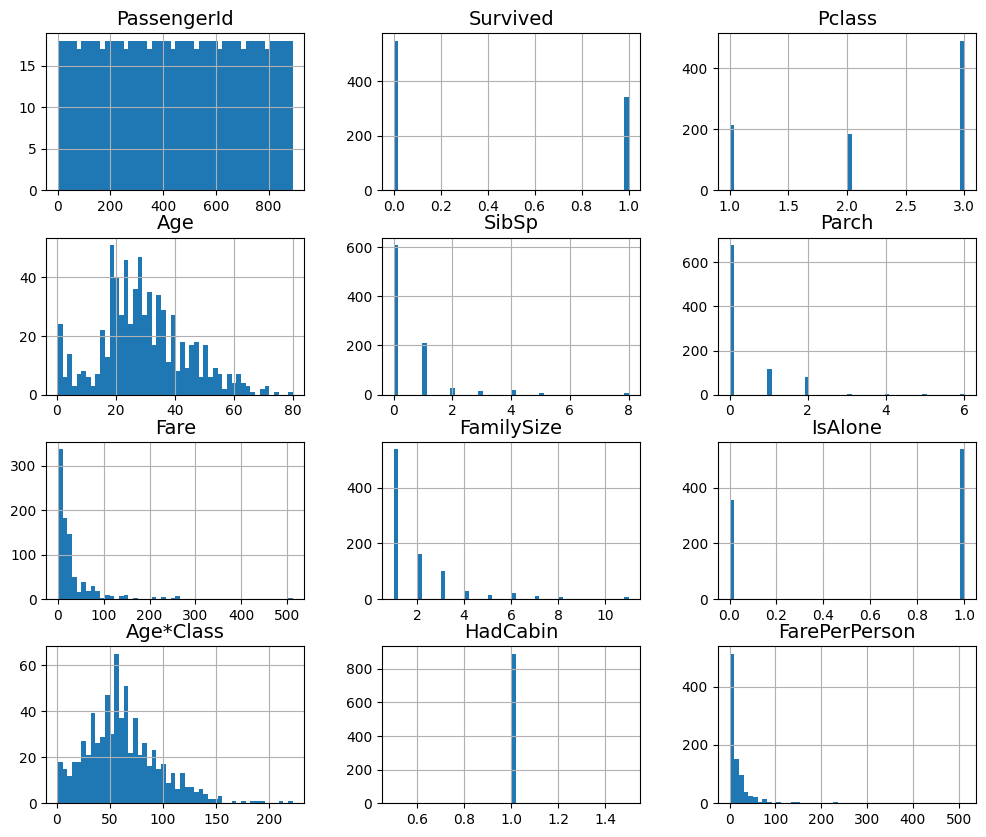

In [8]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

train_set.hist(bins=50, figsize=(12, 10))
plt.show()

In [9]:
#DROPPING THE USELESS FEATURES
train_set = train_set.drop(columns=['PassengerId', 'Name', 'Ticket'])
test_set = test_set.drop(columns=['PassengerId', 'Name', 'Ticket'])

In [10]:
X_train = train_set.drop(columns=['Survived'])
y_train = train_set['Survived']
X_test = test_set.copy()

In [11]:
categorical_cols = train_set.select_dtypes(include='object').columns.difference(['Survived'])
print("Categorical columns:", categorical_cols)
numeric_cols = train_set.select_dtypes(include=np.number).columns.difference(['Survived'])
print("Numeric columns:", numeric_cols)

Categorical columns: Index(['Cabin', 'CabinLetter', 'Embarked', 'Sex', 'TicketPrefix', 'Title'], dtype='object')
Numeric columns: Index(['Age', 'Age*Class', 'FamilySize', 'Fare', 'FarePerPerson', 'HadCabin',
       'IsAlone', 'Parch', 'Pclass', 'SibSp'],
      dtype='object')


## **2) Create a pipeline for a better preprocessing**

In [12]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

log_transformer = make_pipeline(                      
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler()
)

numeric_transformer = make_pipeline(              
    SimpleImputer(strategy="median"),
    StandardScaler()
)

categorical_transformer = make_pipeline(                       
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessor = ColumnTransformer([                       
    ("log", log_transformer, skewed_features),
    
    ("num", numeric_transformer, numeric_cols),

    ("cat", categorical_transformer, categorical_cols),
])

## **3) Train and evaluate different models**

### Logistic regression

In [13]:
#TRAIN A LOGISTIC REGRESSION MODEL
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg = Pipeline([
    ("preprocessor1", preprocessor),
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42)),
])

#EVALUATE THE MODEL
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
y_train_pred_1 = cross_val_predict(log_reg, X_train, y_train, cv=3)

from sklearn.metrics import confusion_matrix
cm_log_reg = confusion_matrix(y_train, y_train_pred_1)

print("Confusion Matrix For Logistic Regression:\n", cm_log_reg)
from sklearn.metrics import precision_score, recall_score
pre_log_reg = precision_score(y_train, y_train_pred_1)
rec_log_reg = recall_score(y_train, y_train_pred_1)
f1_log_reg = f1_score(y_train, y_train_pred_1)

print(f"Recall: {rec_log_reg}")
print(f"Precision:  {pre_log_reg}")
print(f"F1 Score: {f1_log_reg}")

Confusion Matrix For Logistic Regression:
 [[472  77]
 [ 86 256]]
Recall: 0.7485380116959064
Precision:  0.7687687687687688
F1 Score: 0.7585185185185185


### Random forest classifier

In [14]:
#TRAIN A RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_clf = Pipeline([
    ("preprocessor2", preprocessor),
    ("rf_clf", RandomForestClassifier(random_state=42)),
])
#EVALUATING THE MODEL
y_train_pred_2 = cross_val_predict(rf_clf, X_train, y_train, cv=3)
cm_rf_clf = confusion_matrix(y_train, y_train_pred_2)
print("Confusion matrix for random forest regressor:\n", cm_rf_clf)

pre_rf_clf = precision_score(y_train, y_train_pred_2)
rec_rf_clf = recall_score(y_train, y_train_pred_2)
f1_rf_clf = f1_score(y_train, y_train_pred_2)
print(f"Recall: {rec_rf_clf}")
print(f"Precision:  {pre_rf_clf}")
print(f"F1 Score: {f1_rf_clf}")

Confusion matrix for random forest regressor:
 [[478  71]
 [ 92 250]]
Recall: 0.7309941520467836
Precision:  0.778816199376947
F1 Score: 0.7541478129713424


### Gradient Boosting classifier

In [15]:
#TRAIN A GradientBoostingClassifier MODEL
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

gb_clf = Pipeline([
    ("preprocessor5", preprocessor),
    ("gb_clf", GradientBoostingClassifier(random_state=42)),
])

#EVALUATE THE MODEL
y_train_pred_5 = cross_val_predict(gb_clf, X_train, y_train, cv=3)
cm_gb_clf = confusion_matrix(y_train, y_train_pred_5)
print("Confusion matrix for GradientBoostingClassifier:\n", cm_gb_clf)
rec_gb_clf = recall_score(y_train, y_train_pred_5)
pre_gb_clf = precision_score(y_train, y_train_pred_5)
f1_gb_clf = f1_score(y_train, y_train_pred_5)
print(f"F1 Score: {f1_gb_clf}")
print(f"Recall: {rec_gb_clf}")
print(f"Precision:  {pre_gb_clf}")

Confusion matrix for GradientBoostingClassifier:
 [[484  65]
 [ 97 245]]
F1 Score: 0.7515337423312882
Recall: 0.716374269005848
Precision:  0.7903225806451613


### Kneighbors classifier

In [16]:
#TRAIN A KNeighborsClassifier MODEL
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

knn_clf = Pipeline([
    ("preprocessor4", preprocessor),
    ("knn_clf", KNeighborsClassifier()),
])  

#EVALUATE THE MODEL

y_train_pred_4 = cross_val_predict(knn_clf, X_train, y_train, cv=3)
cm_knn_clf = confusion_matrix(y_train, y_train_pred_4)
print("Confusion matrix for KNeighborsClassifier:\n", cm_knn_clf)
rec_knn_clf = recall_score(y_train, y_train_pred_4)
pre_knn_clf = precision_score(y_train, y_train_pred_4)
f1_knn_clf = f1_score(y_train, y_train_pred_4)
print(f"Recall: {rec_knn_clf}")
print(f"Precision:  {pre_knn_clf}")
print(f"F1 Score: {f1_knn_clf}")

Confusion matrix for KNeighborsClassifier:
 [[474  75]
 [105 237]]
Recall: 0.6929824561403509
Precision:  0.7596153846153846
F1 Score: 0.7247706422018347


### SVC classifier

In [17]:
#TRAIN A SVC CLASSIFIER
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

svc_clf = Pipeline([
    ("prepocessor3", preprocessor),
    ("svc_clf", SVC(random_state=42, probability=True)),
])

#EVALUATE THE MODEL
y_train_pred_3 = cross_val_predict(svc_clf, X_train, y_train, cv=3)
cm_svc_clf = confusion_matrix(y_train, y_train_pred_3)
print("Confusion matrix for the SVC regressor:\n", cm_svc_clf)

pre_svc_clf = precision_score(y_train, y_train_pred_3)
rec_svc_clf = recall_score(y_train, y_train_pred_3)
f1_svc_clf = f1_score(y_train, y_train_pred_3)
print(f"Recall: {rec_svc_clf}")
print(f"Precision:  {pre_svc_clf}")
print(f"F1 Score: {f1_svc_clf}")

Confusion matrix for the SVC regressor:
 [[488  61]
 [ 93 249]]
Recall: 0.7280701754385965
Precision:  0.8032258064516129
F1 Score: 0.763803680981595


We know understand that the 4 best models are: Random Forest classifier, Gradient Boosting classifier, SVC classifier, Logistic Regression

## **4) Use random search to choose the best hyperparameters**

In [18]:
#RANDOMISE SEARCH FOR RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'rf_clf__n_estimators': [100, 200, 500],
    'rf_clf__max_depth': [None, 5, 10, 20],
    'rf_clf__min_samples_split': [2, 5, 10],
    'rf_clf__min_samples_leaf': [1, 2, 4],
    'rf_clf__max_features': ['sqrt', 'log2', None],
    'rf_clf__bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(rf_clf, rf_params, cv=3, scoring='f1', n_jobs=-1, verbose=0)
rf_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor2',
                                              ColumnTransformer(transformers=[('log',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log1p'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['FarePerPerson',
                                                                                'Fare',
                                                                                'SibSp',
                                                                                'Parch',
                                                                                'Fa...
                                                                               Index(['Cabin', 'CabinLetter', 'Embarked', 'Sex', 'TicketPrefix', 'Title'], dtype='object'))])),
                                             ('rf_clf',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'rf_clf__bootstrap': [True, False],
                                        'rf_clf__max_depth': [None, 5, 10, 20],
                                        'rf_clf__max_features': ['sqrt', 'log2',
                                                                 None],
                                        'rf_clf__min_samples_leaf': [1, 2, 4],
                                        'rf_clf__min_samples_split': [2, 5, 10],
                                        'rf_clf__n_estimators': [100, 200,
                                                                 500]},
                   scoring='f1')

In [19]:
#RANDOMISE SEARCH FOR GRADIENT BOOSTING CLASSIFIER
from sklearn.ensemble import GradientBoostingClassifier

gb_params = {
    'gb_clf__n_estimators': [100, 200, 500],
    'gb_clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gb_clf__max_depth': [3, 5, 10],
    'gb_clf__min_samples_split': [2, 5, 10],
    'gb_clf__min_samples_leaf': [1, 2, 4],
    'gb_clf__subsample': [0.8, 1.0]
}

gb_search =RandomizedSearchCV(gb_clf, gb_params, cv=3, scoring='f1', n_jobs=-1, verbose=0)
gb_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor5',
                                              ColumnTransformer(transformers=[('log',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log1p'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['FarePerPerson',
                                                                                'Fare',
                                                                                'SibSp',
                                                                                'Parch',
                                                                                'Fa...
                                                                               Index(['Cabin', 'CabinLetter', 'Embarked', 'Sex', 'TicketPrefix', 'Title'], dtype='object'))])),
                                             ('gb_clf',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'gb_clf__learning_rate': [0.01, 0.05,
                                                                  0.1, 0.2],
                                        'gb_clf__max_depth': [3, 5, 10],
                                        'gb_clf__min_samples_leaf': [1, 2, 4],
                                        'gb_clf__min_samples_split': [2, 5, 10],
                                        'gb_clf__n_estimators': [100, 200, 500],
                                        'gb_clf__subsample': [0.8, 1.0]},
                   scoring='f1')

In [20]:
#RANDOMISE SEARCH FOR SVC CLASSIFIER
from sklearn.svm import SVC

svc_params = {
    'svc_clf__C': [0.1, 1, 10, 100],
    'svc_clf__kernel': ['linear', 'rbf', 'poly'],
    'svc_clf__gamma': ['scale', 'auto']
}

svc_search = RandomizedSearchCV(svc_clf, svc_params, cv=3, scoring='f1', n_jobs=-1, verbose=0)
svc_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prepocessor3',
                                              ColumnTransformer(transformers=[('log',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log1p'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['FarePerPerson',
                                                                                'Fare',
                                                                                'SibSp',
                                                                                'Parch',
                                                                                'Fam...
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               Index(['Cabin', 'CabinLetter', 'Embarked', 'Sex', 'TicketPrefix', 'Title'], dtype='object'))])),
                                             ('svc_clf',
                                              SVC(probability=True,
                                                  random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'svc_clf__C': [0.1, 1, 10, 100],
                                        'svc_clf__gamma': ['scale', 'auto'],
                                        'svc_clf__kernel': ['linear', 'rbf',
                                                            'poly']},
                   scoring='f1')

In [21]:
#RANDOMISE SEARCH FOR LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

log_params = {
    'log_reg__penalty': ['l1', 'l2'],
    'log_reg__C': [0.01, 0.1, 1, 10, 100]
}

log_search = RandomizedSearchCV(log_reg, log_params, cv=3, scoring='f1', n_jobs=-1, verbose=0)
log_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor1',
                                              ColumnTransformer(transformers=[('log',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log1p'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['FarePerPerson',
                                                                                'Fare',
                                                                                'SibSp',
                                                                                'Parch',
                                                                                'Fa...
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               Index(['Cabin', 'CabinLetter', 'Embarked', 'Sex', 'TicketPrefix', 'Title'], dtype='object'))])),
                                             ('log_reg',
                                              LogisticRegression(max_iter=1000,
                                                                 random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'log_reg__C': [0.01, 0.1, 1, 10, 100],
                                        'log_reg__penalty': ['l1', 'l2']},
                   scoring='f1')

In [22]:
print("Best RF:", rf_search.best_params_)
print("Best GB:", gb_search.best_params_)
print("Best SVC:", svc_search.best_params_)
print("Best LogReg:", log_search.best_params_)

Best RF: {'rf_clf__n_estimators': 500, 'rf_clf__min_samples_split': 10, 'rf_clf__min_samples_leaf': 4, 'rf_clf__max_features': 'sqrt', 'rf_clf__max_depth': 20, 'rf_clf__bootstrap': False}
Best GB: {'gb_clf__subsample': 1.0, 'gb_clf__n_estimators': 100, 'gb_clf__min_samples_split': 5, 'gb_clf__min_samples_leaf': 1, 'gb_clf__max_depth': 3, 'gb_clf__learning_rate': 0.05}
Best SVC: {'svc_clf__kernel': 'poly', 'svc_clf__gamma': 'scale', 'svc_clf__C': 10}
Best LogReg: {'log_reg__penalty': 'l2', 'log_reg__C': 1}


## **5) Assemble the four models in one model**

In [23]:
#WE CAN ASSEMBLE ALL THE 4 MODELS TOGETHER
from sklearn.ensemble import VotingClassifier

model_1 = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=500, max_depth=20, random_state=42, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', bootstrap=False))
])

model_2 = Pipeline([
    ("preprocessor", preprocessor),
    ("lr", LogisticRegression(C=1, penalty='l2', random_state=42))
])

model_3 = Pipeline([
    ("preprocessor", preprocessor),
    ("svc", SVC(C=10, gamma='scale', kernel='poly', random_state=42, probability=True))
])

model_4 = Pipeline([
    ("preprocessor", preprocessor),
    ("gb", GradientBoostingClassifier(subsample=1.0, min_samples_split=5, min_samples_leaf=1, n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42))
])

ensemble_model = VotingClassifier(estimators=[
    ('rf', model_1), 
    ('lr', model_2), 
    ('svc', model_3), 
    ('gb', model_4)], voting='soft') 

ensemble_model.fit(X_train, y_train)

y_train_pred = ensemble_model.predict(X_train)

recall = recall_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)

print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Recall: 0.827485380116959
Precision: 0.884375
F1 Score: 0.8549848942598187


### We can see that we have create a solid model!!